In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Utils.hedging_utils as hu
import Utils.greeks as gr
import Utils.option_pricing_utils as opu

In [33]:
option_exposure = -100000  # Number of options held in portfolio that we want to hedge
S0 = 49
r = 0.05
mu=0.1
sigma = 0.2
q = 0
T = 20/52 
K = 50
type = 'c'
M=100000
N=1

In [34]:
np.seterr(divide='ignore')
T_array = np.linspace(T, 0, M)
dt = T_array[1] - T_array[2]
S = hu.simulate_gbm(S0, T_array, sigma, mu, q, M)
bs_price_array = opu.get_bs_price_analytical(S, K, T_array, sigma, r, q, type, display_result=False)*(-option_exposure)
delta_array = gr.get_delta(S, K, T_array, sigma, r, q, type)
gamma_array = gr.get_gamma(S, K, T_array, sigma, r, q, type)
theta_array = gr.get_theta(S, K, T_array, sigma, r, q, type)

hedging_df = pd.DataFrame(zip(S, delta_array, bs_price_array), columns=['Stock_Price', 'Delta', 'BS_Price'])
hedging_df['Stock_Price_Change'] = hedging_df['Stock_Price'].sub(hedging_df['Stock_Price'].shift())
hedging_df['Shares_Held'] = -option_exposure*hedging_df['Delta']
hedging_df['Total_Stock_Position'] = hedging_df['Shares_Held']*hedging_df['Stock_Price']
hedging_df['Money_Market_Position'] = np.nan
hedging_df['Money_Market_Position'].iloc[0] = hedging_df['BS_Price'].iloc[0] - hedging_df['Total_Stock_Position'].iloc[0]
hedging_df['Interest'] = np.nan
hedging_df['Interest'].iloc[0] = 0
hedging_df['Hedging_Portfolio_Value'] = hedging_df['Total_Stock_Position'] + hedging_df['Money_Market_Position']

for i in range(1, len(T_array)):
    hedging_df['Interest'].iloc[i] = hedging_df['Money_Market_Position'].iloc[i-1]*r*dt
    hedging_df['Hedging_Portfolio_Value'].iloc[i] = hedging_df['Hedging_Portfolio_Value'].iloc[i-1] + hedging_df['Shares_Held'].iloc[i-1]*hedging_df['Stock_Price_Change'].iloc[i] + hedging_df['Interest'].iloc[i]
    hedging_df['Money_Market_Position'].iloc[i] = hedging_df['Hedging_Portfolio_Value'].iloc[i] - hedging_df['Total_Stock_Position'].iloc[i]
hedging_df['Delta_Hedge_Portfolio_Value'] = hedging_df['Hedging_Portfolio_Value'].sub(hedging_df['BS_Price'])
hedging_df['Hedge_Portfolio_PnL'] = hedging_df['Delta_Hedge_Portfolio_Value'].sub(hedging_df['Delta_Hedge_Portfolio_Value'].shift())
hedging_df['Portfolio_Gamma_Contribution'] = 1/2*gamma_array*option_exposure*hedging_df['Stock_Price_Change']**2
hedging_df['Portfolio_Theta_Contribution'] = theta_array*option_exposure*dt

hedging_df

c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:19: RuntimeWarning: invalid value encountered in true_divide
  return norm.pdf(d1)/(S*sigma*np.sqrt(T))
c:\Users\Matthew\Documents\Python Scripts\Option_Pricing\Utils\greeks.py:26: RuntimeWarning: invalid value encountered in true_divide
  theta_call = -r*K*np.exp(-r*T)*norm.cdf(d2) - S*norm.pdf(d1)*sigma/(2*np.sqrt(T))


,Stock_Price,Delta,BS_Price,Stock_Price_Change,Shares_Held,Total_Stock_Position,Money_Market_Position,Interest,Hedging_Portfolio_Value,Delta_Hedge_Portfolio_Value,Hedge_Portfolio_PnL,Portfolio_Gamma_Contribution,Portfolio_Theta_Contribution
0,49.000000,5.216047e-01,2.400527e+05,NaN,5.216047e+04,2.555863e+06,-2.315810e+06,0.000000,240052.732327,-2.328306e-10,NaN,NaN,1.657554e+02
1,48.844520,5.113107e-01,2.318576e+05,-0.155480,5.113107e+04,2.497473e+06,-2.265574e+06,-44.579389,231898.237884,4.064659e+01,40.646594,-7.960007e+01,1.645940e+02
2,48.794513,5.079327e-01,2.291447e+05,-0.050007,5.079327e+04,2.478433e+06,-2.249135e+06,-43.612350,229297.726303,1.530095e+02,112.362921,-8.248453e+00,1.642411e+02
3,48.925835,5.165034e-01,2.357065e+05,0.131322,5.165034e+04,2.527036e+06,-2.291111e+06,-43.295896,235924.696189,2.182192e+02,65.209732,-5.672228e+01,1.653569e+02
4,48.824002,5.097137e-01,2.303163e+05,-0.101833,5.097137e+04,2.488626e+06,-2.258005e+06,-44.103935,230620.888370,3.045456e+02,86.326311,-3.421544e+01,1.645975e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,41.792228,1.083218e-115,1.549676e-112,0.047787,1.083218e-110,4.527008e-109,1.706561e+03,0.032851,1706.560887,1.706561e+03,0.032851,-8.626012e-112,1.016886e-110
996,41.962523,9.440812e-147,1.041481e-143,0.170295,9.440812e-142,3.961603e-140,1.706594e+03,0.032851,1706.593738,1.706594e+03,0.032851,-1.238737e-141,1.159057e-141
997,41.892838,3.839211e-223,2.795053e-220,-0.069685,3.839211e-218,1.608354e-216,1.706627e+03,0.032852,1706.626590,1.706627e+03,0.032852,-1.278903e-218,7.121191e-218
998,41.936900,0.000000e+00,0.000000e+00,0.044061,0.000000e+00,0.000000e+00,1.706659e+03,0.032853,1706.659443,1.706659e+03,0.032853,-0.000000e+00,0.000000e+00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Hedging PnL: $1706.6922959623482


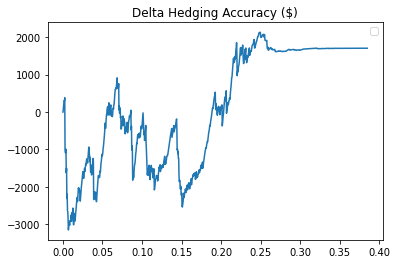

In [35]:
# Plot Delta-Hedge PnL
hedging_pnl = hedging_df['Delta_Hedge_Portfolio_Value'].iloc[-1]
print(f'Hedging PnL: ${hedging_pnl}')
plt.plot(np.flip(T_array), hedging_df['Delta_Hedge_Portfolio_Value'])
plt.legend()
plt.title('Delta Hedging Accuracy ($)')
#plt.ylim(-1, 1)
plt.show()


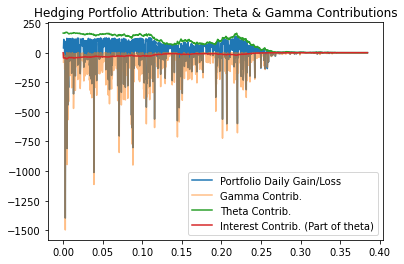

In [40]:
# Plot Delta-Hedge PnL
plt.plot(np.flip(T_array), hedging_df['Hedge_Portfolio_PnL'], label='Portfolio Daily Gain/Loss')
plt.plot(np.flip(T_array), hedging_df['Portfolio_Gamma_Contribution'], alpha=0.5, label='Gamma Contrib.')
plt.plot(np.flip(T_array), hedging_df['Portfolio_Theta_Contribution'], label='Theta Contrib.')
plt.plot(np.flip(T_array), hedging_df['Interest'], label='Interest Contrib. (Part of theta)')

plt.legend()
plt.title('Hedging Portfolio Attribution: Theta & Gamma Contributions')
plt.show()


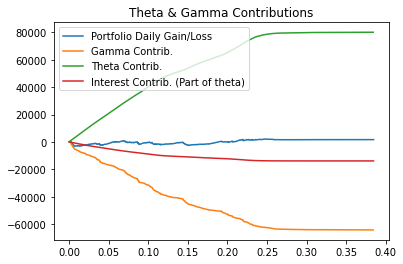

In [41]:
# Plot Delta-Hedge PnL
plt.plot(np.flip(T_array), hedging_df['Hedge_Portfolio_PnL'].cumsum(), label='Portfolio Daily Gain/Loss')
plt.plot(np.flip(T_array), hedging_df['Portfolio_Gamma_Contribution'].cumsum(), label='Gamma Contrib.')
plt.plot(np.flip(T_array), hedging_df['Portfolio_Theta_Contribution'].cumsum(), label='Theta Contrib.')
plt.plot(np.flip(T_array), hedging_df['Interest'].cumsum(), label='Interest Contrib. (Part of theta)')

plt.legend()
plt.title('Theta & Gamma Contributions')
plt.show()
